In [37]:
import json
import os
from pathlib import Path
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

In [2]:
all_files = os.listdir('./data/wikipedia')
print(len(all_files))

3532330


In [ ]:
import argparse
from pathlib import Path
from tqdm import tqdm

def prune(directory: Path, keep_every: int = 10, dry_run: bool = False):
    count = kept = deleted = 0
    for i, entry in tqdm(enumerate(directory.iterdir()), total=3532330):
        if not entry.is_file():
            continue
        if i % keep_every:
            deleted += 1
            if not dry_run:
                entry.unlink()
        else:
            kept += 1
        count += 1
    return count, kept, deleted

target = Path('./data/wikipedia/')
#prune(target)

100%|██████████| 3532330/3532330 [11:40<00:00, 5044.97it/s] 


(3532330, 353233, 3179097)

In [38]:
def get_vocab_size_dict_from_folder(folder, prefix_filter = None):
    tokenizer_paths_folder = Path(folder)

    if prefix_filter == None:
        subfolders = [f for f in tokenizer_paths_folder.iterdir() if f.is_dir()]
    else:
        subfolders = [f for f in tokenizer_paths_folder.iterdir() if f.is_dir() and f.name.startswith(prefix_filter)]

    vocabularies = []
    for subfolder in tqdm(subfolders):
        tokenizer_path = subfolder / 'tokenizer.json'
        if tokenizer_path.exists():
            with open(tokenizer_path, 'r') as f:
                
                tokenizer_data = json.load(f)
            tokens = tokenizer_data['model']['vocab']
            vocabularies.append(tokens)

    vocab_size_dict = {}
    vocab_sizes = []
    for vocab in tqdm(vocabularies):
        vocab_size = len(vocab)
        vocab_sizes.append(vocab_size)
        token_lengths = [len(token) for token in vocab.keys() if len(token) <= 20]
        vocab_size_dict[vocab_size] = token_lengths


    vocab_size_dict = dict(sorted(vocab_size_dict.items()))

    return vocab_size_dict


small_data_vocab = get_vocab_size_dict_from_folder('./tokenizers', 'size_')
big_data_vocab = get_vocab_size_dict_from_folder('./tokenizers/wikipedia', 'size_')

small_keys = list(small_data_vocab.keys())
big_keys = list(big_data_vocab.keys())

joint_keys = list(set(small_keys).intersection(set(big_keys)))
joint_keys.sort()


100%|██████████| 42/42 [00:00<00:00, 372.57it/s]


In [ ]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import imageio.v2 as imageio          # ≥2.31 recommended
import io

# --- 1. Figure-building helper ---------------------------------------------
def build_comparison_figure(key, comparison_data, relative=False):
    fig, ax = plt.subplots(figsize=(16, 8))

    max_length = 0
    for name, vocab_collection in comparison_data.items():
        token_lengths = vocab_collection[key]
        max_length = max(max_length, max(token_lengths))
        counts = Counter(token_lengths)

        xs = np.array(sorted(counts))
        ys = np.array([counts[x] for x in xs])
        if relative:
            ys = ys / ys.sum()

        ax.plot(xs, ys, label=name, linewidth=2)

    max_length = 21 # min(20, max_length)
    ax.set(
        title=f"Distribution of token lengths – size {key:>8}",
        xlabel="Token length",
        ylabel="Relative count" if relative else "Count",
        xticks=range(0, max_length + 1),
    )
    ax.set_ylim(top=14000, bottom=-0.01)  
    ax.legend()
    ax.grid(True)
    return fig  # <-- return, don’t show


# --- 2. Loop over keys, collect PNG frames ---------------------------------
dicts = {
    "small_data": small_data_vocab,
    "big_data": big_data_vocab,
}

frames = []
for key in sorted(set(small_data_vocab) & set(big_data_vocab)):
    fig = build_comparison_figure(key, dicts, relative=False)

    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=100)   # <-  remove bbox_inches="tight"
    buf.seek(0)
    frames.append(imageio.imread(buf))
    plt.close(fig)


# --- 3. Write a single looping GIF -----------------------------------------
imageio.mimsave(
    "token_length_distributions.gif",  # output file
    frames,
    duration=1.5,   # seconds per frame
    loop=0,         # 0 = loop forever
)


GIF saved as token_length_distributions.gif


In [8]:
tokenizer_paths_folder = Path('./tokenizers/wikipedia')
subfolders = [f for f in tokenizer_paths_folder.iterdir() if f.is_dir() and f.name.startswith('size_')]

vocabularies = []
for subfolder in tqdm(subfolders):
    tokenizer_path = subfolder / 'tokenizer.json'
    if tokenizer_path.exists():
        with open(tokenizer_path, 'r') as f:
            
            tokenizer_data = json.load(f)
        tokens = tokenizer_data['model']['vocab']
        vocabularies.append(tokens)

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 32.54it/s]


In [9]:
vocab_size_dict = {}
raw_vocab_size_dict = {}
vocab_sizes = []
for vocab in tqdm(vocabularies):
    vocab_size = len(vocab)
    vocab_sizes.append(vocab_size)
    token_lengths = [len(token) for token in vocab.keys() if len(token) <= 20]
    raw_token_lengths = [len(token) for token in vocab.keys()]
    vocab_size_dict[vocab_size] = token_lengths
    raw_vocab_size_dict[vocab_size] = raw_token_lengths
# sort vocab_size_dict by key
vocab_size_dict = dict(sorted(vocab_size_dict.items()))
raw_vocab_size_dict = dict(sorted(raw_vocab_size_dict.items()))


100%|██████████| 14/14 [00:00<00:00, 167.30it/s]


In [8]:
len(vocab_sizes)

3

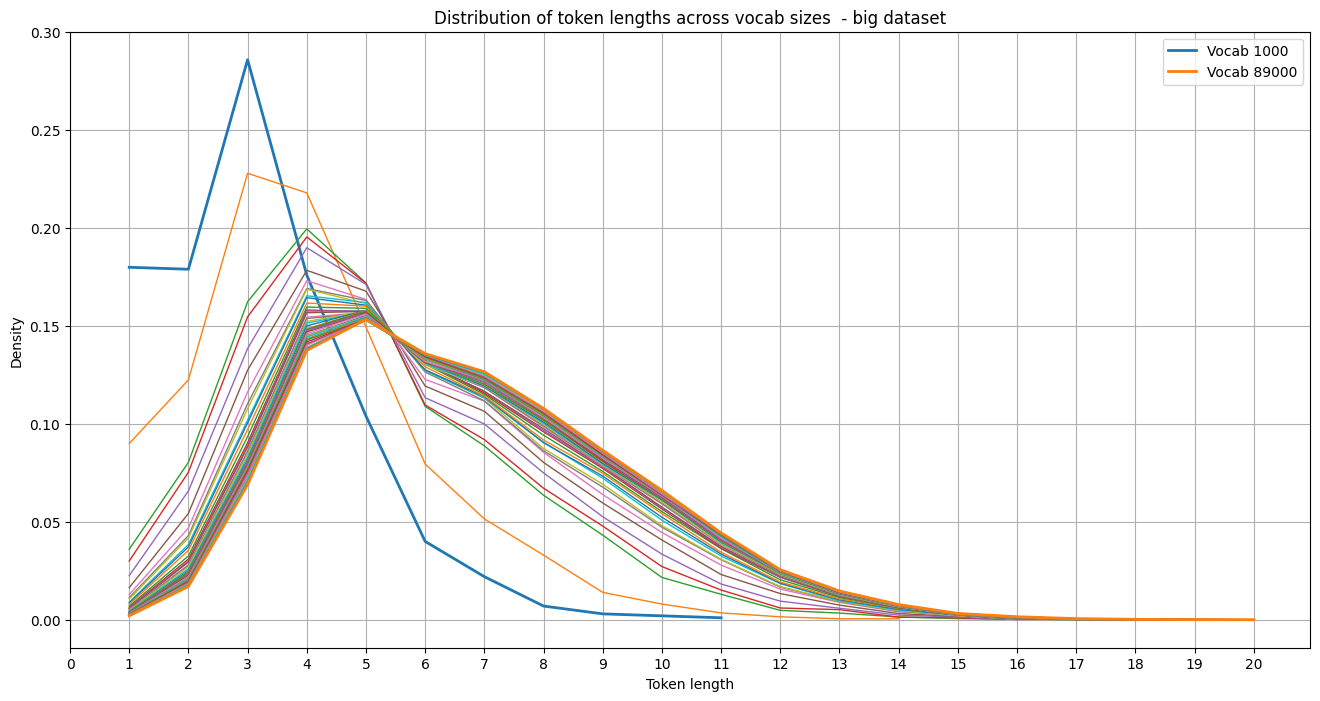

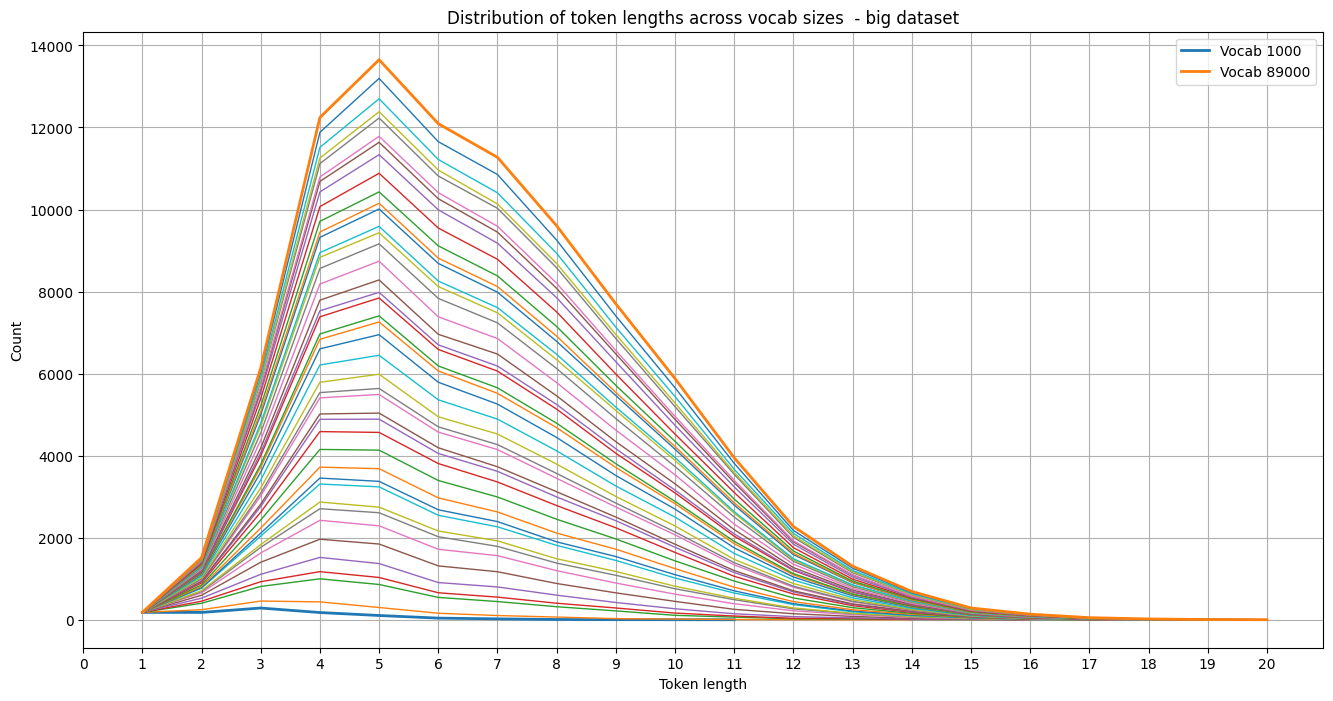

In [40]:
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt


def plot_distributions(vocab_size_dict, filename = None, relative = False, title_suffix = ""):
    smallest_vocab_len = min(vocab_size_dict.keys())
    biggest_vocab_len = max(vocab_size_dict.keys())

    plt.figure(figsize=(16, 8))
    for vocab_len, token_lengths in vocab_size_dict.items():
        # build (x,y)
        counts = Counter(token_lengths)
        xs = np.array(sorted(counts))
        if relative:
            ys = np.array([counts[x] for x in xs]) / sum(counts.values())
        else:
            ys = np.array([counts[x] for x in xs])

        # piecewise linear line
        if vocab_len in [smallest_vocab_len, biggest_vocab_len]:
            plt.plot(xs, ys, label=f"Vocab {vocab_len}", linewidth=2)
        else:
            plt.plot(xs, ys, linewidth=1)

    plt.title(f"Distribution of token lengths across vocab sizes {title_suffix}")
    plt.xlabel("Token length")
    if relative:
        plt.ylabel("Density")
    else:
        plt.ylabel("Count")
    plt.legend()
    plt.xticks(range(0, 21, 1))
    plt.grid(True)
    if filename is not None:
        plt.savefig(os.path.join("images", filename), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

plot_distributions(big_data_vocab, filename = "big_data_relative.png", relative=True, title_suffix=" - big dataset")
plot_distributions(big_data_vocab, filename = "big_data_nonrelative.png", relative=False, title_suffix=" - big dataset")


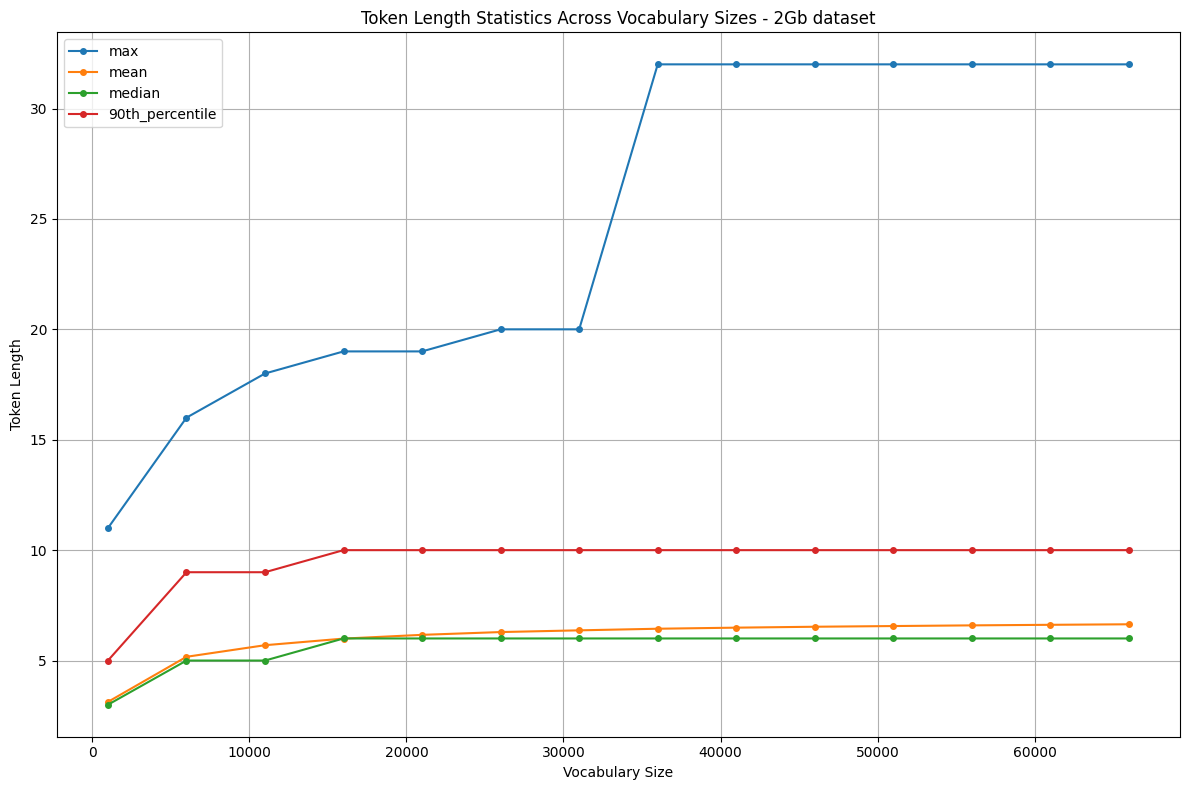

In [10]:
# Calculate statistics for each vocabulary size
stats = {
    'max': [],
    'mean': [],
    'median': [],
    '90th_percentile': []
}
vocab_sizes = []

for vocab_len, token_lengths in raw_vocab_size_dict.items():
    vocab_sizes.append(vocab_len)
    stats['max'].append(max(token_lengths))
    stats['mean'].append(np.mean(token_lengths))
    stats['median'].append(np.median(token_lengths))
    stats['90th_percentile'].append(np.percentile(token_lengths, 90))

# Create the plot
plt.figure(figsize=(12, 8))

for stat_name, values in stats.items():
    plt.plot(vocab_sizes, values, label=stat_name, marker='o', markersize=4)

plt.title("Token Length Statistics Across Vocabulary Sizes - 2Gb dataset")
plt.xlabel("Vocabulary Size")
plt.ylabel("Token Length")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join("images", "wikipedia_token_length_statistics.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()


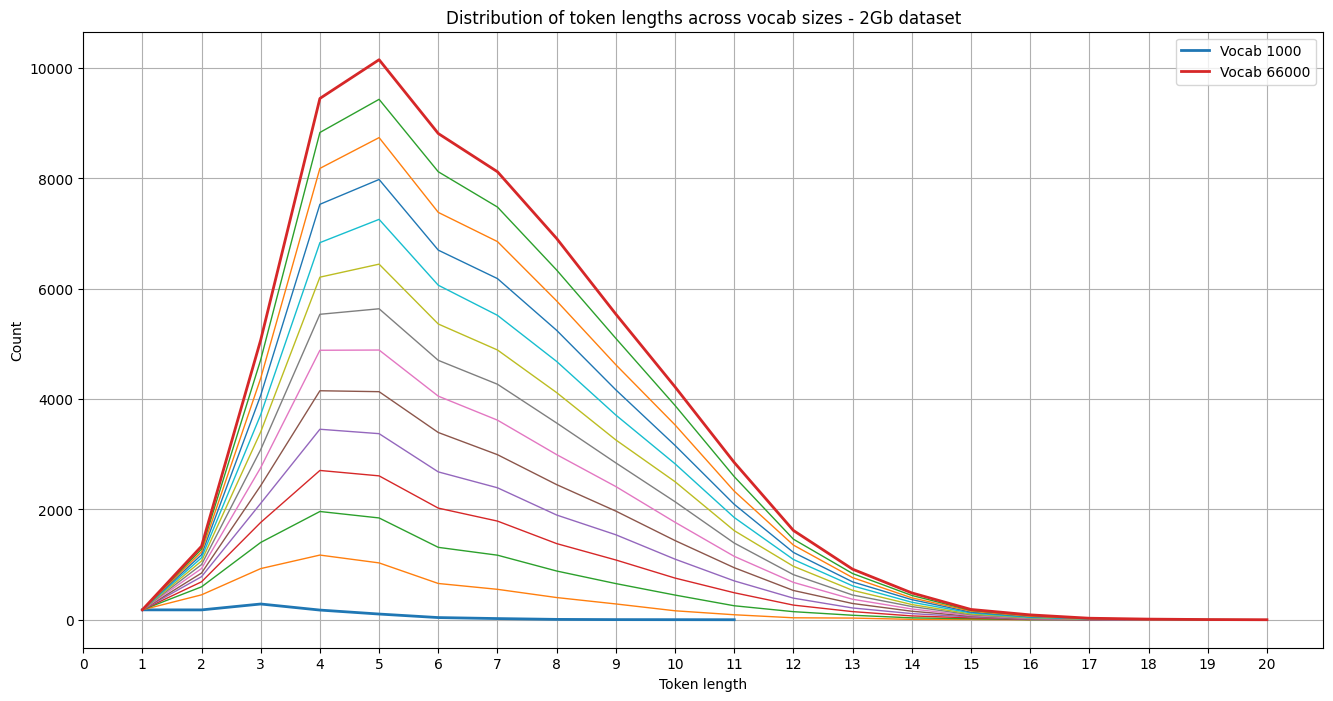

In [ ]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

smallest_vocab_len = min(vocab_size_dict.keys())
biggest_vocab_len = max(vocab_size_dict.keys())

plt.figure(figsize=(16, 8))
for vocab_len, token_lengths in vocab_size_dict.items():
    # build (x,y)
    counts = Counter(token_lengths)
    xs = np.array(sorted(counts))
    ys = np.array([counts[x] for x in xs])# / sum(counts.values())

    # piecewise linear line
    if vocab_len in [smallest_vocab_len, biggest_vocab_len]:
        plt.plot(xs, ys, label=f"Vocab {vocab_len}", linewidth=2)
    else:
        plt.plot(xs, ys, linewidth=1)

plt.title(f"Distribution of token lengths across vocab sizes - 2Gb dataset")
plt.xlabel("Token length")
plt.ylabel("Count")
plt.legend()
plt.xticks(range(0, 21, 1))
plt.grid(True)
plt.savefig(os.path.join("images", f"wikipedia_length_distribution_jagged_unrelativized.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [49]:
import numpy as np
from collections import Counter

# suppose token_lengths is a list of ints
counts = Counter(token_lengths)
xs = np.array(sorted(counts))         # unique token lengths
ys = np.array([counts[x] for x in xs])  # raw counts

# if you want a density instead of raw counts:
ys = ys / ys.sum()                    # now sums to 1

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
for vocab_len, token_lengths in vocab_size_dict.items():

    if vocab_len in range(1000, 10000, 1000):
        # build (x,y)
        counts = Counter(token_lengths)
        xs = np.array(sorted(counts))
        ys = np.array([counts[x] for x in xs]) / sum(counts.values())

        # piecewise linear line

        plt.plot(xs, ys, label=f"Vocab {vocab_len}", linewidth=1)

plt.title(f"Distribution of token lengths across vocab sizes")
plt.xlabel("Token length")
plt.ylabel("Density")
plt.legend(ncol=3)
plt.xticks(range(0, 21, 1))
plt.grid(True)
plt.savefig(os.path.join("images", f"length_distribution_jagged_start.png"), dpi=300, bbox_inches='tight')
plt.close()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from pathlib import Path
from tqdm import tqdm


# Calculate statistics for each vocabulary size
stats = {
    'max': [],
    'mean': [],
    'median': [],
    '90th_percentile': []
}
vocab_sizes = []

for vocab_len, token_lengths in raw_vocab_size_dict.items():
    vocab_sizes.append(vocab_len)
    stats['max'].append(max(token_lengths))
    stats['mean'].append(np.mean(token_lengths))
    stats['median'].append(np.median(token_lengths))
    stats['90th_percentile'].append(np.percentile(token_lengths, 90))

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

# First subplot with all statistics (including max)
for stat_name, values in stats.items():
    ax1.plot(vocab_sizes, values, label=stat_name, marker='o', markersize=4)

ax1.set_title("All Token Length Statistics")
ax1.set_xlabel("Vocabulary Size")
ax1.set_ylabel("Token Length")
ax1.legend()
ax1.grid(True)

# Second subplot with all statistics except max
for stat_name, values in stats.items():
    if stat_name != 'max':  # Skip the max statistic for the second plot
        ax2.plot(vocab_sizes, values, label=stat_name, marker='o', markersize=4)

ax2.set_title("Token Length Statistics (without max)")
ax2.set_xlabel("Vocabulary Size")
ax2.legend()
ax2.grid(True)

# Ensure images directory exists
os.makedirs("images", exist_ok=True)

# Save the plot
plt.tight_layout()
plt.savefig(os.path.join("images", "token_length_statistics_comparison.png"), dpi=300, bbox_inches='tight')
plt.close()

print("Side-by-side plots created and saved to 'images/token_length_statistics_comparison.png'")

Side-by-side plots created and saved to 'images/token_length_statistics_comparison.png'


In [7]:
# Calculate mean statistic for each vocabulary size
mean_values = []
vocab_sizes = []

for vocab_len, token_lengths in raw_vocab_size_dict.items():
    vocab_sizes.append(vocab_len)
    mean_values.append(np.mean(token_lengths))

# Create a single plot with log scale for y-axis
plt.figure(figsize=(12, 8))

plt.plot(vocab_sizes, mean_values, label='Mean Token Length', marker='o', markersize=4, color='blue')

plt.title("Mean Token Length Across Vocabulary Sizes")
plt.xlabel("Vocabulary Size (log scale")
plt.ylabel("Mean Token Length)")
plt.xscale('log')  # Set y-axis to log scale
plt.legend()
plt.grid(True, which="both", ls="-")  # Grid lines for both major and minor ticks

# Ensure images directory exists
os.makedirs("images", exist_ok=True)

# Save the plot
plt.tight_layout()
plt.savefig(os.path.join("images", "mean_token_length_log_scale.png"), dpi=300, bbox_inches='tight')
plt.close()
